### Contextual Bandit Algorithms

In [87]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

np.random.seed(592)

Here we implement Thompson Sampling where the prior is known:

In [88]:
def thompson_sampling_true_prior(horizon, num_simulations, num_arms):

    # This is our prior
    prior_mean = np.zeros(num_arms)
    prior_cov = np.eye(num_arms)

    regrets = np.zeros(num_simulations)
    
    for sim in range(num_simulations):
        
        # Sample from the prior to get arm means (normal distribution in num_arms dimensions)
        arm_means = np.random.multivariate_normal(prior_mean, prior_cov)
        best_arm_mean = np.max(arm_means)

        # Initial posterior for all arms is just prior: N(0,1)
        arm_means_posterior = np.zeros(num_arms)
        arm_vars_posterior = np.ones(num_arms)

        sample_totals = np.zeros(num_arms)
        sample_counts = np.zeros(num_arms)

        # Now the reward distribution for each arm i is N(arm_means[i], 1)
        for _ in range(horizon):
            # Compute posterior for each arm 
            for i in range(num_arms):
                arm_means_posterior[i] = (sample_totals[i]) / (sample_counts[i] + 1)
                arm_vars_posterior[i] = 1 / (sample_counts[i] + 1)

            # Sample from each posterior distribution
            posterior_samples = [np.random.normal(arm_means_posterior[i], np.sqrt(arm_vars_posterior[i])) for i in range(num_arms)]

            # Choose the arm with the highest sample
            chosen_arm = np.argmax(posterior_samples)

            # Sample from the reward distribution of the chosen arm N(ui, 1)
            reward = np.random.normal(arm_means[chosen_arm], 1)
            sample_totals[chosen_arm] += reward
            sample_counts[chosen_arm] += 1

            # Update regret
            regrets[sim] += best_arm_mean - arm_means[chosen_arm]
        
    return regrets

And here we implement Thompson Sampling when the prior is unknown (i.e. uniform):

In [89]:
def thompson_sampling_uniform_prior(horizon, num_simulations, num_arms):

    # This is our prior
    prior_mean = np.zeros(num_arms)
    prior_cov = np.eye(num_arms)

    regrets = np.zeros(num_simulations)
    
    for sim in range(num_simulations):

        # Sample from the prior to get arm means (normal distribution in num_arms dimensions)
        arm_means = np.random.multivariate_normal(prior_mean, prior_cov)
        best_arm_mean = np.max(arm_means)

        # Initial posterior for all arms
        arm_means_posterior = np.zeros(num_arms)
        arm_vars_posterior = np.ones(num_arms)

        sample_totals = np.zeros(num_arms)
        sample_counts = np.zeros(num_arms)

        # Now the reward distribution for each arm i is N(arm_means[i], 1)
        for _ in range(horizon):
            # Compute posterior for each arm - this looks slightly different since our prior is uniform
            # We handle divide by zero later
            for i in range(num_arms):
                arm_means_posterior[i] = (sample_totals[i]) / (sample_counts[i])
                arm_vars_posterior[i] = 1 / (sample_counts[i])

            # Create posterior_samples array
            posterior_samples = np.zeros(num_arms)

            # Identify arms with at least one sample
            valid_arms = sample_counts > 0
            invalid_arms = ~valid_arms  # Arms with zero counts

            # Truncated normal sampling for valid arms
            if np.any(valid_arms):  # Ensure there are valid arms before sampling
                lower, upper = -1, 1
                mu_valid = arm_means_posterior[valid_arms]
                sigma_valid = np.sqrt(arm_vars_posterior[valid_arms])

                a = (lower - mu_valid) / sigma_valid
                b = (upper - mu_valid) / sigma_valid

                posterior_samples[valid_arms] = truncnorm.rvs(a, b, loc=mu_valid, scale=sigma_valid)

            # Uniform sampling for invalid arms
            posterior_samples[invalid_arms] = np.random.uniform(-1, 1, np.sum(invalid_arms))


            #print(posterior_samples)
            # Choose the arm with the highest sample
            chosen_arm = np.argmax(posterior_samples)

            # Sample from the reward distribution of the chosen arm N(ui, 1)
            reward = np.random.normal(arm_means[chosen_arm], 1)
            sample_totals[chosen_arm] += reward
            sample_counts[chosen_arm] += 1

            # Update regret
            regrets[sim] += best_arm_mean - arm_means[chosen_arm]
        
    return regrets

Now we plot regret vs horizon for each algorithm:

In [90]:
def plot_regret(k, num_simulations, horizons):

    regrets_true_prior = []
    regrets_uniform_prior = []
    
    for horizon in horizons:
        regrets_true_prior.append(np.mean(thompson_sampling_true_prior(horizon, num_simulations, k)))
        regrets_uniform_prior.append(np.mean(thompson_sampling_uniform_prior(horizon, num_simulations, k)))
    
    plt.figure(figsize=(8, 6))
    plt.plot(horizons, regrets_true_prior, marker='o', label='True Prior')
    plt.plot(horizons, regrets_uniform_prior, marker='s', label='Uniform Prior')
    
    plt.xscale('log')
    plt.xlabel('Horizon (log scale)')
    plt.ylabel('Average Regret')
    plt.title('Regret Comparison: True Prior vs. Uniform Prior')
    plt.legend()
    
    plt.show()


/var/folders/mf/2cn54l592v59ftz5czx_4x_m0000gn/T/ipykernel_62062/113256545.py:27: RuntimeWarning: invalid value encountered in scalar divide
  arm_means_posterior[i] = (sample_totals[i]) / (sample_counts[i])
/var/folders/mf/2cn54l592v59ftz5czx_4x_m0000gn/T/ipykernel_62062/113256545.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  arm_vars_posterior[i] = 1 / (sample_counts[i])


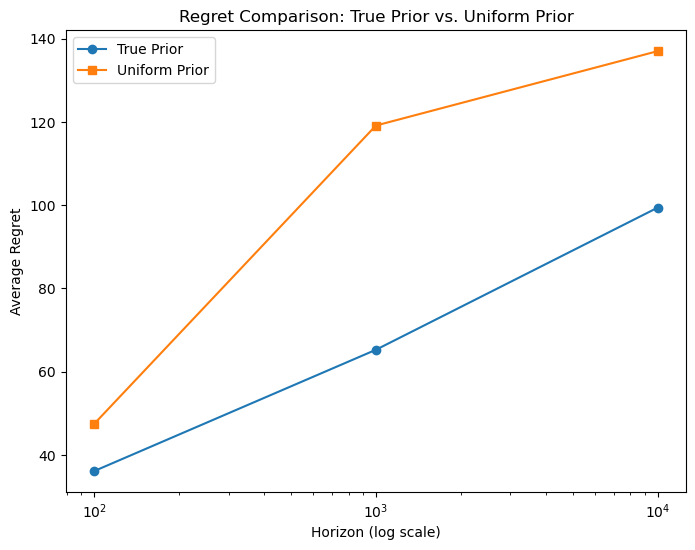

In [91]:
plot_regret(k = 10, num_simulations = 50, horizons = [100, 1000, 10000])

Now we will study Thompson Sampling and UCB with different gap parameters. For Thompson Sampling, we will keep the prior as N(0,1). For UCB, we will use $\delta = \frac{1}{n}$ and $\beta=1$ since each arm is Gaussian with $\sigma^2=1$.

In [92]:
def thompson_sampling_gap(gap, horizon, num_simulations):
    num_arms = 10
    arm_means = np.array([1/2] + [1/2 - gap] + [-1/2] * (num_arms - 2))
    arm_vars = np.ones(num_arms)  # All arms have variance 1
    best_arm_mean = np.max(arm_means)
    
    regrets = np.zeros(num_simulations)
    
    for sim in range(num_simulations):
        # Initial posterior for all arms is just prior: N(0,1)
        arm_means_posterior = np.zeros(num_arms)
        arm_vars_posterior = np.ones(num_arms)

        sample_totals = np.zeros(num_arms)
        sample_counts = np.zeros(num_arms)

        # Run the Thompson Sampling algorithm
        for _ in range(horizon):
            # Compute posterior for each arm 
            for i in range(num_arms):
                arm_means_posterior[i] = sample_totals[i] / (sample_counts[i] + 1)
                arm_vars_posterior[i] = 1 / (sample_counts[i] + 1)

            # Sample from each posterior distribution
            posterior_samples = [np.random.normal(arm_means_posterior[i], np.sqrt(arm_vars_posterior[i])) for i in range(num_arms)]

            # Choose the arm with the highest sample
            chosen_arm = np.argmax(posterior_samples)

            # Sample from the reward distribution of the chosen arm
            reward = np.random.normal(arm_means[chosen_arm], 1)
            sample_totals[chosen_arm] += reward
            sample_counts[chosen_arm] += 1

            # Update regret
            regrets[sim] += best_arm_mean - arm_means[chosen_arm]
    
    # Compute average regret and standard error
    avg_regret = np.mean(regrets)
    std_error = np.std(regrets) / np.sqrt(num_simulations)
    
    return avg_regret, std_error

In [93]:
def ucb_gap(gap, horizon, num_simulations):
    num_arms = 10
    arm_means = np.array([1/2] + [1/2 - gap] + [-1/2] * (num_arms - 2))
    arm_vars = np.ones(num_arms)  # All arms have variance 1
    best_arm_mean = np.max(arm_means)
    
    regrets = []

    for _ in range(num_simulations):
        rewards = np.zeros(num_arms)  # Empirical rewards
        pulls = np.zeros(num_arms)    # Number of pulls for each arm

        total_regret = 0

        # First 10 rounds: Pull each arm once to initialize
        for t in range(num_arms):
            reward = np.random.normal(arm_means[t], 1)
            rewards[t] = reward
            pulls[t] = 1
            total_regret += best_arm_mean - arm_means[t]

        # For the remaining rounds (from round 11 to horizon)
        for t in range(num_arms, horizon):
 
            ucb_values = rewards / pulls + np.sqrt(2 * np.log(2 * horizon**2 * num_arms) / pulls)

            # Select the arm with the highest UCB and pull
            selected_arm = np.argmax(ucb_values)
            reward = np.random.normal(arm_means[selected_arm], 1)

            # Update the rewards and pulls
            pulls[selected_arm] += 1
            rewards[selected_arm] += reward

            # Calculate the regret for this step
            total_regret += best_arm_mean - arm_means[selected_arm]

        regrets.append(total_regret)

    
    avg_regret = np.mean(regrets)
    std_error = np.std(regrets) / np.sqrt(num_simulations)
    return avg_regret, std_error


Now we will plot results:

In [94]:
def plot_regret_gaps(gaps, horizon, num_simulations):
    thompson_avg_regrets = []
    thompson_std_errors = []
    ucb_avg_regrets = []
    ucb_std_errors = []
    
    for gap in gaps:
        avg_regret, std_error = thompson_sampling_gap(gap, horizon, num_simulations)
        thompson_avg_regrets.append(avg_regret)
        thompson_std_errors.append(std_error)
        
        avg_regret, std_error = ucb_gap(gap, horizon, num_simulations)
        ucb_avg_regrets.append(avg_regret)
        ucb_std_errors.append(std_error)
    
    plt.figure(figsize=(8, 6))
    plt.errorbar(gaps, thompson_avg_regrets, yerr=thompson_std_errors, marker='o', label='Thompson Sampling')
    plt.errorbar(gaps, ucb_avg_regrets, yerr=ucb_std_errors, marker='s', label='UCB')
    
    plt.xlabel('Gap')
    plt.ylabel('Average Regret')
    plt.title('Regret Comparison: Thompson Sampling vs. UCB')
    plt.legend()
    
    plt.show()

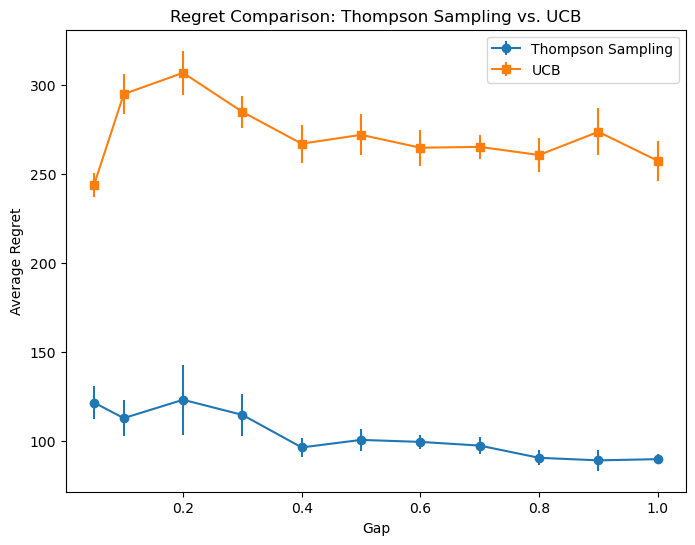

In [95]:
gaps = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plot_regret_gaps(gaps, horizon=2000, num_simulations=10)